---
### *The 12th Computational Neuroscience Winter School*

# Tutorial II: Neuron software
---
__Date:__ Jan. 13, 2023

__Content Creator:__ Jingyang Ma, Ziling Wang, Kai Chen, Songting Li

# Tutorial Objectives

In this notebook, we'll learn how to use the Neuron software in python to build the biophysical neuron(or neuronal network) and do some simulations as we like. There are 4 sections in this tutorial:

1. Simulation of  a point neuron
1. Simulation of neuron with dendtrites
1. Simulation of neuronal network
1. Simulation of a real neuron from ModelDB

#### References:
- https://www.neuron.yale.edu/neuron/static/py_doc/index.html
- https://neuronaldynamics.epfl.ch
- https://senselab.med.yale.edu/ModelDB/
- Li, S., Liu, N., Zhang, X., Zhou, D., Cai, D. (2014) Bilinearity in spatiotemporal integration of synaptic inputs. PLoS Comput Biol.
- Li, S., Liu, N., Zhang, X., McLaughlin, D. W., Zhou, D., & Cai, D. (2019). Dendritic computations captured by an effective point neuron model. Proceedings of the National Academy of Sciences.
- Hay E, Hill S, Schürmann F, Markram H, Segev I (2011) Models of Neocortical Layer 5b Pyramidal Cells Capturing a Wide Range of Dendritic and Perisomatic Active Properties. PLoS Comput Biol.

# Neuron software introduction

![NERUON](./pictures/NEURON.png)

![bilinear](./pictures/bilinear.png)

NEURON is a simulation software used to simulate a single neuron or neuronal network. It is suitable to simulate neurons with complex geometry and abundant ion channels and their neural circuits. The feature of this software is that when conducting numerical simulation, users only need to consider the geometric shape parameters of neurons, biophysical parameters and connections between neurons and other information, without considering the numerical solution method behind.

It was primarily developed by Michael Hines, John W. Moore, and Ted Carnevale at Yale and Duke in 1997. A NEURON project usually has three code formats:.hoc,.mod, and.ses. And use a specific software to do some simulation(see below). Today we mainly focus on the Python interface of NEURON which is more convenient and easy to learn.

![Neurongui](./pictures/Neurongui.png)

---
# Setup

Use **pip3 install neuron** to install the neuron package in python

In [1]:
!pip3 install neuron

There are only a limited number of functions avaiable directly from the neuron module. In practice, we usually want to directly import the submodules we need

In [2]:
from neuron import h

--No graphics will be displayed.


NEURON assumes certain default units (concentration in mM, time in ms, voltage in mV), but units can be specified explicitly by importing unit definitions from neuron.units. Even if you are using the default units, being explicit makes your code more readable by others. For example:

In [3]:
from neuron.units import ms, mV

# Section 1: Simulation of  a point neuron

## Step 1: Create a soma and check its morphological properties

A **Section** is the basic morphological building-block in NEURON. We typically think of a Section as an unbranched cable(cylinder), but it can also be used to represent a soma. Thus a simple model neuron with only a soma can be created as in:

In [4]:
soma = h.Section(name='soma')

![soma](./pictures/soma.png)

Every NEURON section has a **psection** method (think: properties of the section) that returns a Python dictionary providing a structured data representation of the properties of the section.
For example, we can query the soma via:

In [5]:
soma.psection()

{'point_processes': {},
 'density_mechs': {},
 'ions': {},
 'morphology': {'L': 100.0,
  'diam': [500.0],
  'pts3d': [],
  'parent': None,
  'trueparent': None},
 'nseg': 1,
 'Ra': 35.4,
 'cm': [1.0],
 'regions': set(),
 'species': set(),
 'name': 'soma',
 'hoc_internal_name': '__nrnsec_0x55598a90cc90',
 'cell': None}

NEURON itself has default unit for different Physical quantities. And we can use **h.units()** to check it

In [6]:
h.units('L')

'um'

The results tell us the soma is a cylinder with length 100 microns, diameter 500 microns, axial resistivity 35.4 ohm*cm, and specific membrance capacitance 1 μF/cm2.

Since this is a dictionary, we can extract any properties we want using square brackets. For example, the length of the section is:

In [7]:
soma.psection()['morphology']['L']

100.0

All of these values can be individually accessed in more efficient ways, but psection provides an overview of the full properties of the section.

For example, the length of the soma is more efficiently available via:

In [8]:
soma.L

100.0

Important: You may have noticed that the default diameter is 500 μm, which is excessively large for mammalian neurons. It's the default because it's appropriate for the squid giant axons studied by Hodgkin and Huxley. NEURON also uses squid-relevant values for axial resistivity (soma.Ra) and temperature (h.celsius). These should all be adjusted for mammalian models.

## Step 2: Change the default value

Since we're simulating a soma, the default length of 100 μm and diameter of 500 μm are inappropriate. Let's set the length (L) and diameter (diam) to 20 μm instead:

In [9]:
soma.L = 20
soma.diam = 20

In [10]:
soma.psection()

{'point_processes': {},
 'density_mechs': {},
 'ions': {},
 'morphology': {'L': 20.0,
  'diam': [20.0],
  'pts3d': [],
  'parent': None,
  'trueparent': None},
 'nseg': 1,
 'Ra': 35.4,
 'cm': [1.0],
 'regions': set(),
 'species': set(),
 'name': 'soma',
 'hoc_internal_name': '__nrnsec_0x55598a90cc90',
 'cell': None}

## Step 3: Insert ion channels

The cell membrane consists of a thin bilayer of lipids and is a nearly perfect electrical insulator. Embedded in the cell membrane are, however, specific proteins which act as ion gates. A first type of gate is the ion pumps, a second one is ion channels. Ion pumps actively transport ions from one side to the other. As a result, ion concentrations in the intracellular liquid differ from those of the surround. For example, the sodium concentration inside a mammalian neuron (≈ 10 mM) is lower than that in the extracellular liquid (≈ 145 mM). On the other hand, the potassium concentration inside is higher (≈ 140 mM) than in the surround (≈ 5 mM) (Purves et al., 2008). For the giant axon of the squid which was studied by Hodgkin and Huxley the numbers are slightly different, but the basic idea is the same: there is more sodium outside the cell than inside, while the reverse is true for potassium.

![ionchannel](./pictures/ionchannel.png)

NEURON comes with a few built in biophysical mechanisms that can be added to a model:

**pas**:	Passive (“leaky”) channel.

**hh**:	Hodgkin-Huxley sodium, potassium, and leakage channels.

Thousands of additional mechanisms (for A-currents, etc) are available as MOD files as part of published model codes on ModelDB(https://senselab.med.yale.edu/ModelDB/).

A section's insert method is used to insert density mechanisms. Let's insert Hodgkin-Huxley channels into the soma's membrane. We do this by passing 'hh' as the mechanism type:

In [11]:
soma.insert('hh')

soma

In [12]:
soma.psection()

{'point_processes': {},
 'density_mechs': {'hh': {'gnabar': [0.12],
   'gkbar': [0.036],
   'gl': [0.0003],
   'el': [-54.3],
   'gna': [0.0],
   'gk': [0.0],
   'il': [0.0],
   'm': [0.0],
   'h': [0.0],
   'n': [0.0]}},
 'ions': {'na': {'ena': [50.0],
   'nai': [10.0],
   'nao': [140.0],
   'ina': [0.0],
   'dina_dv_': [0.0]},
  'k': {'ek': [-77.0],
   'ki': [54.4],
   'ko': [2.5],
   'ik': [0.0],
   'dik_dv_': [0.0]}},
 'morphology': {'L': 20.0,
  'diam': [20.0],
  'pts3d': [],
  'parent': None,
  'trueparent': None},
 'nseg': 1,
 'Ra': 35.4,
 'cm': [1.0],
 'regions': set(),
 'species': set(),
 'name': 'soma',
 'hoc_internal_name': '__nrnsec_0x55598a90cc90',
 'cell': None}

## Step 4: Insert a stimulus

Let's insert a current clamp (an IClamp object) into the center of the soma to induce some membrane dynamics.

In [13]:
iclamp = h.IClamp(soma(0.5))

In particular, we notice three key properties of a current clamp: amp -- the amplitude (in nA), delay -- the time the current clamp switches on (in ms), and dur -- how long (in ms) the current clamp stays on. Let's set these values:

In [43]:
iclamp.delay = 2
iclamp.dur = 0.1
iclamp.amp = 0.9

We can also use the **dir()** function to check all the callable properties of the variable

In [30]:
dir(iclamp)

['__abs__',
 '__add__',
 '__bool__',
 '__call__',
 '__class__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__next__',
 '__pos__',
 '__radd__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__rsub__',
 '__rtruediv__',
 '__setattr__',
 '__setitem__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 'amp',
 'baseattr',
 'delay',
 'dur',
 'get_loc',
 'get_segment',
 'has_loc',
 'hname',
 'hocobjptr',
 'i',
 'loc',
 'same']

Let's use psection to get a representation of the soma model:

In [31]:
soma.psection()

{'point_processes': {'IClamp': {IClamp[0]}},
 'density_mechs': {'hh': {'gnabar': [0.12],
   'gkbar': [0.036],
   'gl': [0.0003],
   'el': [-54.3],
   'gna': [1.069994825530933e-05],
   'gk': [0.0003686530736316609],
   'il': [-0.0032012963057306545],
   'm': [0.05312757001842004],
   'h': [0.5946056924621688],
   'n': [0.3181111680281356]}},
 'ions': {'na': {'ena': [50.0],
   'nai': [10.0],
   'nao': [140.0],
   'ina': [-0.0012301836190995329],
   'dina_dv_': [1.0699948255329592e-05]},
  'k': {'ek': [-77.0],
   'ki': [54.4],
   'ko': [2.5],
   'ik': [0.004434532362394413],
   'dik_dv_': [0.0003686530736339566]}},
 'morphology': {'L': 20.0,
  'diam': [20.0],
  'pts3d': [],
  'parent': None,
  'trueparent': None},
 'nseg': 1,
 'Ra': 35.4,
 'cm': [1.0],
 'regions': set(),
 'species': set(),
 'name': 'soma',
 'hoc_internal_name': '__nrnsec_0x55598a90cc90',
 'cell': None}

## Step 5: Run the simulation and record the data

The cell should be configured to run a simulation. However, we need to indicate which variables we wish to record; these will be stored in a **NEURON Vector** (h.Vector object). For now, we will record the membrane potential, which is soma(0.5).v and the corresponding time points (h.t). References to variables are available by preceding the last part of the variable name with a _ref_

In [32]:
v = h.Vector().record(soma(0.5)._ref_v)             # Membrane potential vector
t = h.Vector().record(h._ref_t)                     # Time stamp vector

By default, the NEURON h module provides the low level fadvance function for advancing one time step. For higher-level simulation control specification, we load NEURON's stdrun library:

In [33]:
h.load_file('stdrun.hoc')

1.0

By theory, the equations for the HH model of the point neuron are:

$$
C\frac{du}{dt}=-g_{Na}m^3h(u-E_{Na})-g_Kn^4(u-E_K)-g_L(u-E_L)+I(t)
$$
$$
\dot{m} = -\frac{1}{\tau_m(u)}(m-m_0(u))
$$
$$
\dot{n} = -\frac{1}{\tau_n(u)}(n-n_0(u))
$$
$$
\dot{h} = -\frac{1}{\tau_h(u)}(h-h_0(u))
$$

By default, it uses the implicit Backward Euler scheme to solve the ODEs:

$$
\frac{y_{n+1}-y_n}{\Delta t}=f(y_{n+1},t_{n+1})
$$

But in NEURON, there is no need to understand the equations but just let the program run it!

By default, the time step dt is 0.025ms

In [34]:
h.dt

0.025

We can then initialize our simulation such that our cell has a resting membrane potential of -65 mV:

In [35]:
h.finitialize(-65 * mV)

1.0

And now continue the simulation from the current time (0) until 40 ms:

In [36]:
h.continuerun(40 * ms)

0.0

Strictly speaking, we didn't need to specify the units here -- recall they were defined above in the from neuron.units import ms, mV -- as they are the defaults assumed by NEURON, but it is good practice to be explicitly clear.

## Step 6: Plot the result and save the data

Here I use the matplotlib package the sketch the result. But of course you can use other methods you like to do the same thing.

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

The t,v are the hoc.HocObjects but not the arrays which can't be printed out directly

In [38]:
type(t), type(v)

(hoc.HocObject, hoc.HocObject)

In [39]:
print(t)

Vector[7]


Otherwise, we can convert it to **array** to print out

In [40]:
tnp = np.array(t)
print(tnp)

[0.0000e+00 2.5000e-02 5.0000e-02 ... 3.9950e+01 3.9975e+01 4.0000e+01]


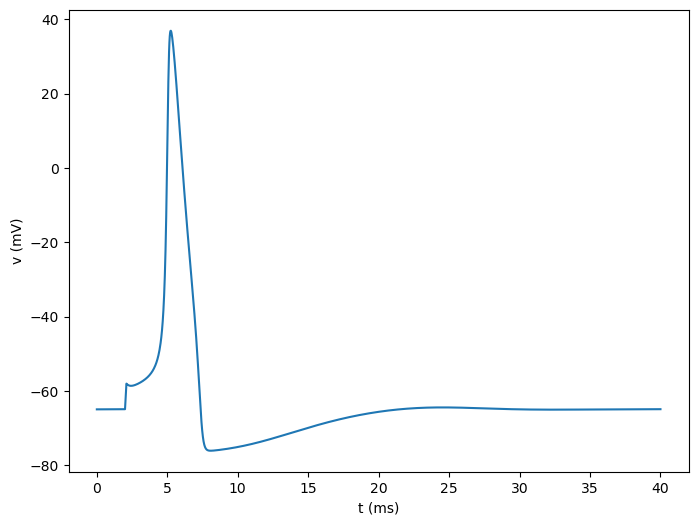

In [53]:
iclamp.amp = 0.9
h.finitialize(-65 * mV)
h.continuerun(40 * ms)
plt.figure(figsize=(8,6))
plt.plot(t, v)
plt.xlabel('t (ms)')
plt.ylabel('v (mV)')
plt.show()

We can also record the ion current similar to the way we record the voltage

In [45]:
v = h.Vector().record(soma(0.5)._ref_v)             # Membrane potential vector
t = h.Vector().record(h._ref_t)                     # Time stamp vector
ina = h.Vector().record(soma(0.5)._ref_ina)
ik = h.Vector().record(soma(0.5)._ref_ik)      

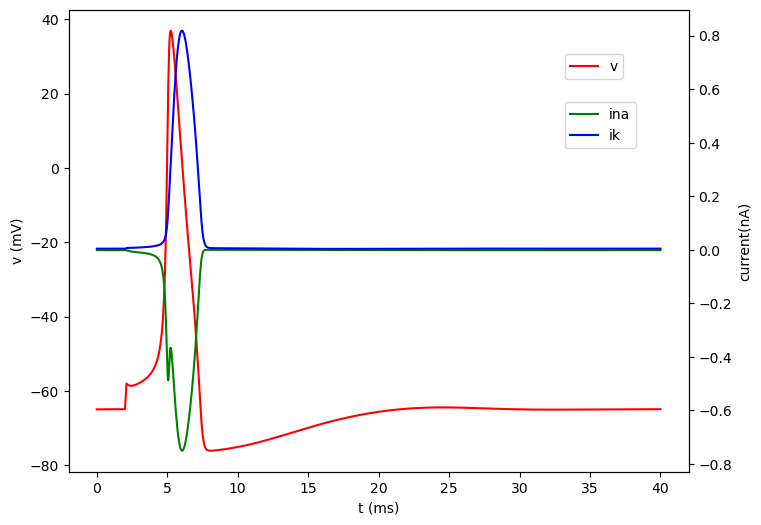

In [54]:
h.finitialize(-65 * mV)
h.continuerun(40 * ms)
fig, ax1 = plt.subplots(figsize=(8,6))
ax2 = ax1.twinx()
ax1.plot(t, v, label='v', c='r')
ax2.plot(t, ina, label='ina', c='g')
ax2.plot(t, ik, label='ik', c='b')
ax1.set_xlabel('t (ms)')
ax1.set_ylabel('v (mV)')
ax2.set_ylabel('current(nA)')
ax1.legend(loc=(0.8, 0.85))
ax2.legend(loc=(0.8, 0.7))

Pickles are a Python-specific data exchange format.
Python provides the pickle module to read and write pickled files. We load it via:

In [47]:
import pickle

Save the data as a dictionary

In [48]:
with open('data.p', 'wb') as f: # data.p is the file name
    pickle.dump({'t': t, 'v': v}, f)

Load the data

In [49]:
with open('data.p', 'rb') as f:
    data = pickle.load(f)
tnewp = data['t']
vnewp = data['v']

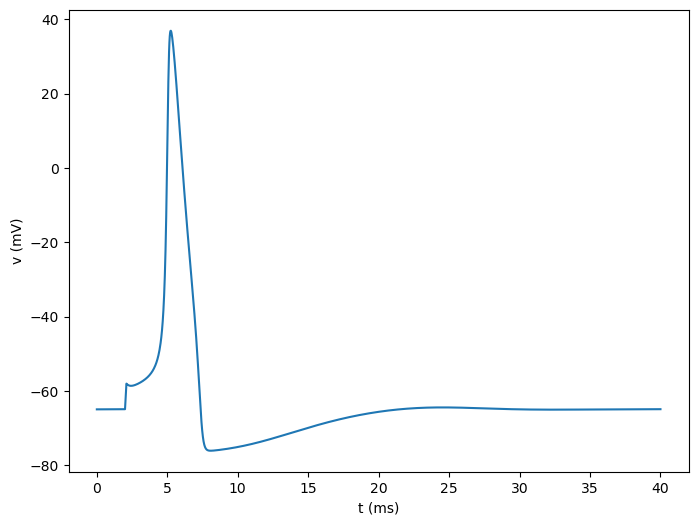

In [55]:
plt.figure(figsize=(8,6))
plt.plot(tnewp, vnewp)
plt.xlabel('t (ms)')
plt.ylabel('v (mV)')
plt.show()

## Exercise 1: Try to create a soma with radius of 5um and insert the soma with HH channels. And simulate the soma with a current input of 0.9nA and 0.8nA respectively(delay=0 and dur=0.1). What's the  difference of the membrance potential?

In [8]:
## Uncomment the line below and fill in the blank
# from neuron import h
# from neuron.units import ms, mV
# %matplotlib inline
# import matplotlib.pyplot as plt
# import numpy as np

# h.load_file('stdrun.hoc')

# soma = ... ## create a soma
# soma.L = ... ## change the length
# ... = ... ## change the diameter

# soma.insert(...) ## insert the HH channels

# iclamp = ... ## insert the current input
# iclamp.delay = ... ## define the delay
# iclamp.dur = ... ## define the duration

# v = ... ## record the voltage
# t = ... ## record the time

# for i in range(2):
    # iclamp.amp = 0.8 + i * 0.1

    # h.finitialize(-65 * mV)
    # h.continuerun(40 * ms)

    # plt.figure(figsize=(8,6))
    # plt.title(f'current is {0.8 + i * 0.1} nA')
    # plt.plot(t, v)
    # plt.xlabel('t(ms)')
    # plt.ylabel('V(mV)')